# Podcast Exploration

In [12]:
import mne
import numpy as np
from mne_bids import BIDSPath

In [13]:
file_path = BIDSPath(root="derivatives/ecogprep",
                     subject="02",
                     task="podcast",
                     datatype="ieeg",
                     description="highgamma",
                     suffix="ieeg",
                     extension="fif")
print(f"File path within the dataset: {file_path}")

File path within the dataset: derivatives/ecogprep/sub-02/ieeg/sub-02_task-podcast_desc-highgamma_ieeg.fif


In [14]:
raw = mne.io.read_raw_fif(f"/om2/data/public/fietelab/ecog-the-podcast/{file_path}", verbose=False)
raw

<Raw | sub-02_task-podcast_desc-highgamma_ieeg.fif, 90 x 921600 (1800.0 s), ~129 kB, data not loaded>

In [15]:
data = raw.get_data()
print(f"Data is a {type(data)} object and has a shape of: {data.shape}")

Data is a <class 'numpy.ndarray'> object and has a shape of: (90, 921600)


In [16]:
print("First channel name is:", raw.info.ch_names[0])
print("Metadata associated with the first channel:")
raw.info['chs'][0]

First channel name is: PO1
Metadata associated with the first channel:


{'scanno': 1,
 'logno': 1,
 'kind': 902 (FIFFV_ECOG_CH),
 'range': 1.0,
 'cal': 1.0,
 'coil_type': 1 (FIFFV_COIL_EEG),
 'loc': array([-0.06466667, -0.051     , -0.01066667,  0.        ,  0.        ,
         0.        ,         nan,         nan,         nan,         nan,
                nan,         nan]),
 'unit': 107 (FIFF_UNIT_V),
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'ch_name': 'PO1',
 'coord_frame': 4 (FIFFV_COORD_HEAD)}

In [17]:
from nilearn.plotting import plot_markers

In [18]:
ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

Coordinate matrix shape:  (90, 3)


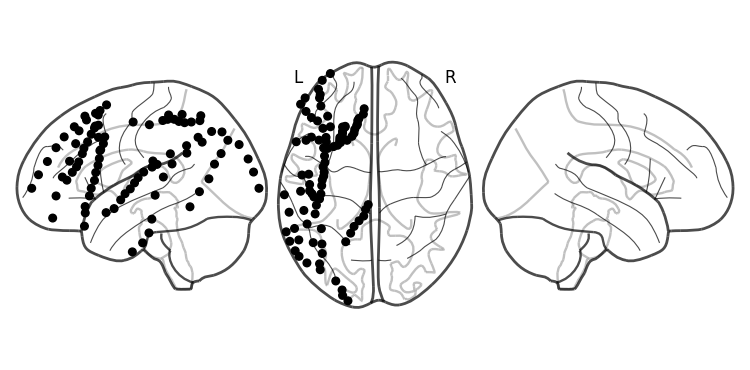

In [19]:
values = np.ones(len(coords))
fig = plot_markers(values, coords,
             node_size=30, display_mode='lzr', alpha=1,
             node_cmap='Grays', colorbar=False, node_vmin=0, node_vmax=1)
print(fig)

In [20]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile
from scipy.stats import pearsonr, zscore
from mne_bids import BIDSPath
from functools import partial
from nilearn.plotting import plot_markers

In [21]:
ecog_data = raw.get_data()
print(f"ECoG data has a shape of: {ecog_data.shape}")

ECoG data has a shape of: (90, 921600)


In [22]:
audio_path = f"/om2/data/public/fietelab/ecog-the-podcast/stimuli/podcast.wav"
audio_sf, audio_wave = wavfile.read(audio_path)

print(f"Audio waveform is sampled at {audio_sf} Hz and has a shape of: {audio_wave.shape}")

# We will arbitrarily select the first channel from the stereo audio
if audio_wave.ndim > 1:
    audio_wave = audio_wave[:, 0]

Audio waveform is sampled at 44100 Hz and has a shape of: (79380000, 2)


/tmp/ipykernel_1614847/1876989002.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  audio_sf, audio_wave = wavfile.read(audio_path)


In [23]:
from IPython.display import Audio
Audio(audio_wave[:audio_sf*30], rate=audio_sf)

In [24]:
def preprocess_raw_audio(x, fs, to_fs, lowcut=200, highcut=5000):

    # See https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = signal.butter(order, [low, high], btype="band")
        return b, a

    def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = signal.lfilter(b, a, data)
        return y

    assert x.ndim == 1

    # Step 1. Bandpass the high quality audio
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=5)

    # Step 2. Downsample to same freq as clinical system
    # Number of new samples is N = n * (to_fs / fs)
    y = signal.resample(y, num=round(x.size / fs * to_fs))

    # Step 3. Take audio envelope
    envelope = np.abs(signal.hilbert(y - y.mean()))

    return envelope

In [25]:
ecog_sr = raw.info['sfreq']
audio_power = preprocess_raw_audio(audio_wave, audio_sf, ecog_sr)

print(f"Audio power is sampled at {ecog_sr} Hz and has a shape of: {audio_power.shape}")

Audio power is sampled at 512.0 Hz and has a shape of: (921600,)


In [26]:
n_electrodes = ecog_data.shape[0]
correlations = np.zeros(n_electrodes)
for i in range(len(ecog_data)):
    result = pearsonr(audio_power, ecog_data[i])
    correlations[i] = result.statistic

Coordinate matrix shape:  (90, 3)


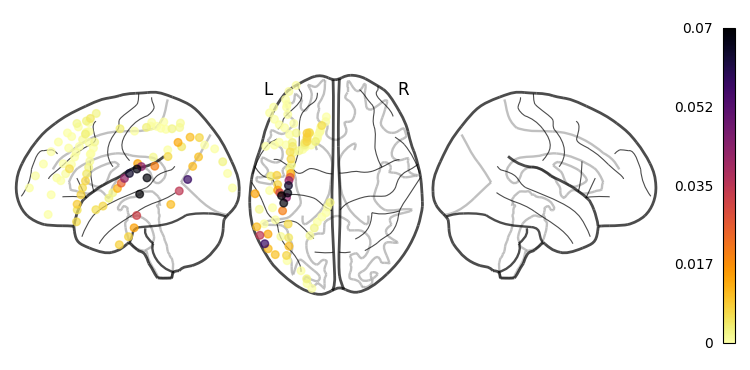

In [27]:
ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

# order will ensure that the highest correlations are plotted on top (last)
order = correlations.argsort()
plot_markers(correlations[order], coords[order],
             node_size=30, display_mode='lzr',
             node_vmin=0, node_cmap='inferno_r', colorbar=True)
plt.show()

In [28]:
transcript_path = f"/om2/data/public/fietelab/ecog-the-podcast/stimuli/podcast_transcript.csv"
df = pd.read_csv(transcript_path)
df.dropna(subset=['start'], inplace=True)
df.sort_values("start", inplace=True)
df.head(10)

word  start    end
0      Act  3.710  3.790
1     one,  3.990  4.190
2   monkey  4.651  4.931
3       in  4.951  5.011
4      the  5.051  5.111
5  middle.  5.151  5.391
6       So  6.592  6.732
7  there's  6.752  6.912
8     some  6.892  7.052
9   places  7.072  7.342

In [29]:
events = np.zeros((len(df), 3))
events[:, 0] = df.start
print(f"events array has a shape of: {events.shape}")


events array has a shape of: (5136, 3)


In [30]:
# zscore the electrode time series so they're all on the same scale
func = partial(zscore, axis=1)
raw.load_data()
raw = raw.apply_function(func, channel_wise=False)

epochs = mne.Epochs(
    raw,
    (events * raw.info['sfreq']).astype(int),
    tmin=-0.5,
    tmax=1.5,
    baseline=None,
    proj=None,
    event_id=None,
    preload=True,
    event_repeated="merge",
)

print(f"Epochs object has a shape of: {epochs._data.shape}")

Reading 0 ... 921599  =      0.000 ...  1799.998 secs...
Not setting metadata
5136 matching events found
No baseline correction applied
Using data from preloaded Raw for 5136 events and 1025 original time points ...
5 bad epochs dropped
Epochs object has a shape of: (5131, 90, 1025)


In [31]:
evoked = epochs.average()
print(f"Evoked object has a shape of: {evoked.data.shape}")


Evoked object has a shape of: (90, 1025)


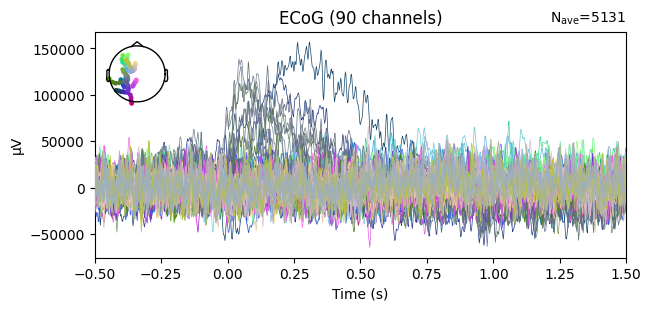

In [32]:
evoked.plot();

Coordinate matrix shape:  (90, 3)


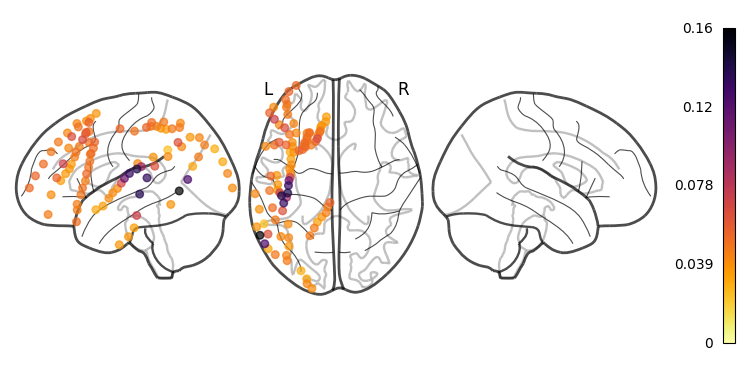

In [33]:
values = evoked.data.max(-1)

ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

order = values.argsort()
plot_markers(values[order], coords[order],
             node_size=30, display_mode='lzr',
             node_vmin=0, node_cmap='inferno_r', colorbar=True)
plt.show()